In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using MLJ, SPI
using Distances
using StatsPlots, StatsBase
using Muon, CSV, DataFrames

In [2]:
rdir = datadir("exp_pro", "BB728") |> mkpath
pdir = plotsdir("CSB_predictivemodel_lasso") |> mkpath
biobank = readh5mu(joinpath(rdir, "BB728.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/ben/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 728 ✕ 21485
└ metabolites_foldchange
  AnnData object 728 ✕ 50
└ metabolites_millimolar
  AnnData object 728 ✕ 10
└ UPorder_oggs
  AnnData object 728 ✕ 10177
└ oggs
  AnnData object 728 ✕ 11248

In [53]:
(biobank["UPorder_oggs"].uns["UP_SVs"].^2 ./ sum(biobank["UPorder_oggs"].uns["UP_SVs"].^2))[2800]

1.834584063453152e-6

In [3]:
biobank[:UPorder_oggs].obsp |> keys

KeySet for a Muon.AlignedMapping{Tuple{1 => 1, 2 => 1}, String, AnnData} with 4 entries. Keys:
  "SDij"
  "SDij_earlywindow"
  "SDij_middlewindow"
  "SDij_latewindow"

In [4]:
BBUhat = biobank[:UPorder_oggs].obsm["inferredLSVs"][:, :];

In [5]:
inBB673 = biobank.obs.inBB673 .== 1;

In [6]:
trnX = BBUhat[inBB673, :]
tstX = BBUhat[.!inBB673, :];


In [45]:
trnXdf |> nrows

223446

In [7]:
train_uppertri = triu(trues(sum(inBB673), sum(inBB673)), 1)
test_uppertri = triu(trues(sum(.!inBB673), sum(.!inBB673)), 1);

In [8]:
trnXdf = DataFrame(mapslices(x->abs.(x.-x')[train_uppertri]|>vec, trnX, dims=1), "x" .* string.(1:size(trnX, 2)));

In [9]:
tstXdf = DataFrame(mapslices(x->abs.(x.-x')[test_uppertri]|>vec, tstX, dims=1), "x" .* string.(1:size(tstX, 2)));

In [10]:
bbmM = biobank["metabolites_millimolar"].X[:, 1:4];

trnYdf = DataFrame(
    :samephylum => (biobank.obs.phylum .== permutedims(biobank.obs.phylum))[inBB673, inBB673][train_uppertri],
    :samefamily => (biobank.obs.family .== permutedims(biobank.obs.family))[inBB673, inBB673][train_uppertri],
    :samespecies=> (biobank.obs.species .== permutedims(biobank.obs.species))[inBB673, inBB673][train_uppertri],
    :samedonor => (biobank.obs.donor .== permutedims(biobank.obs.donor))[inBB673, inBB673][train_uppertri],
    :metdist => Distances.pairwise(Euclidean(), bbmM')[inBB673, inBB673][train_uppertri],
);

tstYdf = DataFrame(
    :samephylum => (biobank.obs.phylum .== permutedims(biobank.obs.phylum))[.!inBB673, .!inBB673][test_uppertri],
    :samefamily => (biobank.obs.family .== permutedims(biobank.obs.family))[.!inBB673, .!inBB673][test_uppertri],
    :samespecies=> (biobank.obs.species .== permutedims(biobank.obs.species))[.!inBB673, .!inBB673][test_uppertri],
    :samedonor => (biobank.obs.donor .== permutedims(biobank.obs.donor))[.!inBB673, .!inBB673][test_uppertri],
);

In [11]:
@load LogisticClassifier pkg=MLJLinearModels
@load MultinomialClassifier pkg=MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/ben/.julia/packages/MLJModels/8Nrhi/src/loading.jl:159


import MLJLinearModels ✔


import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/ben/.julia/packages/MLJModels/8Nrhi/src/loading.jl:159


MLJLinearModels.MultinomialClassifier

In [37]:
mdl = MLJLinearModels.LogisticClassifier(penalty=:l1, lambda=0.001)
cv = StratifiedCV(nfolds=5, shuffle=true);

In [42]:
sml_idxs = sample(1:nrows(trnXdf), 10_000, replace=false);

In [54]:
# mach = machine(mdl, trnXdf[sml_idxs, :], coerce(trnYdf[sml_idxs, :samephylum], OrderedFactor))
mach = machine(mdl, trnXdf[:, :], coerce(trnYdf[:, :samephylum], OrderedFactor))
msrs = [multiclass_f1score, multiclass_precision, multiclass_recall]
sphylum_result = MLJ.evaluate!(mach, resampling=cv, measures=msrs)

┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /Users/ben/.julia/packages/MLJLinearModels/Goxow/src/fit/proxgrad.jl:64
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /Users/ben/.julia/packages/MLJLinearModels/Goxow/src/fit/proxgrad.jl:64


Evaluating over 5 folds:  40%[==========>              ]  ETA: 1:19:23

┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /Users/ben/.julia/packages/MLJLinearModels/Goxow/src/fit/proxgrad.jl:64


Evaluating over 5 folds:  60%[===============>         ]  ETA: 0:57:25

┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /Users/ben/.julia/packages/MLJLinearModels/Goxow/src/fit/proxgrad.jl:64


Evaluating over 5 folds:  80%[====================>    ]  ETA: 0:30:01

┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /Users/ben/.julia/packages/MLJLinearModels/Goxow/src/fit/proxgrad.jl:64


Evaluating over 5 folds: 100%[=========================] Time: 2:25:01


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────────────────────────────┬──────────────┬───────────────
│ measure                                        │ operation    │ measurement  ⋯
├────────────────────────────────────────────────┼──────────────┼───────────────
│ MulticlassFScore(                              │ predict_mode │ 0.966        ⋯
│   β = 1.0,                                     │              │              ⋯
│   average = MLJBase.MacroAvg(),                │              │              ⋯
│   return_type = OrderedCollections.LittleDict) │              │              ⋯
│ MulticlassPrecision(                           │ predict_mode │ 0.966        ⋯
│   average = MLJBase.MacroAvg(),                │              │              ⋯
│   return_type = OrderedCollections.LittleDict) │              │              ⋯
│ Multicla

In [55]:
rdir = projectdir("_research", "BB728_models") |> mkpath

"/Users/ben/projects/Doran_etal_2022/_research/BB728_models"

In [56]:
MLJ.save(joinpath(rdir, "model_phylum_lasso_lambda=0.001.jls"), mach)

In [60]:
MLJ.save(joinpath(rdir, "model_phylum_lasso_lambda=0.001_results.jls"), sphylum_result)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────────────────────────────┬──────────────┬───────────────
│ measure                                        │ operation    │ measurement  ⋯
├────────────────────────────────────────────────┼──────────────┼───────────────
│ MulticlassFScore(                              │ predict_mode │ 0.966        ⋯
│   β = 1.0,                                     │              │              ⋯
│   average = MLJBase.MacroAvg(),                │              │              ⋯
│   return_type = OrderedCollections.LittleDict) │              │              ⋯
│ MulticlassPrecision(                           │ predict_mode │ 0.966        ⋯
│   average = MLJBase.MacroAvg(),                │              │              ⋯
│   return_type = OrderedCollections.LittleDict) │              │              ⋯
│ Multicla

In [ ]:
# mach_sp = machine(mdl, trnXdf[sml_idxs, :], coerce(trnYdf[sml_idxs, :samespecies], OrderedFactor))
mach_fm = machine(mdl, trnXdf[:, :], coerce(trnYdf[:, :samefamily], OrderedFactor))
msrs = [multiclass_f1score, multiclass_precision, multiclass_recall]
sfamily_results = MLJ.evaluate!(mach_sp, resampling=cv, measures=msrs)
MLJ.save(joinpath(rdir, "model_family_lasso_lambda=0.001.jls"), mach_fm)

In [62]:
# mach_sp = machine(mdl, trnXdf[sml_idxs, :], coerce(trnYdf[sml_idxs, :samespecies], OrderedFactor))
mach_sp = machine(mdl, trnXdf[:, :], coerce(trnYdf[:, :samespecies], OrderedFactor))
msrs = [multiclass_f1score, multiclass_precision, multiclass_recall]
sspecies_results = MLJ.evaluate!(mach_sp, resampling=cv, measures=msrs)
MLJ.save(joinpath(rdir, "model_species_lasso_lambda=0.001.jls"), mach_sp)

┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /Users/ben/.julia/packages/MLJLinearModels/Goxow/src/fit/proxgrad.jl:64
┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels /Users/ben/.julia/packages/MLJLinearModels/Goxow/src/fit/proxgrad.jl:64


In [ ]:
# mach_sp = machine(mdl, trnXdf[sml_idxs, :], coerce(trnYdf[sml_idxs, :samespecies], OrderedFactor))
mach_dn = machine(mdl, trnXdf[:, :], coerce(trnYdf[:, :samedonor], OrderedFactor))
msrs = [multiclass_f1score, multiclass_precision, multiclass_recall]
sspecies_results = MLJ.evaluate!(mach_sp, resampling=cv, measures=msrs)
MLJ.save(joinpath(rdir, "model_species_lasso_lambda=0.001.jls"), mach_sp)

In [57]:
findall(last.(fitted_params(mach).coefs) .!= 0.)

59-element Vector{Int64}:
    5
   20
   30
   35
   50
 6360
 6498
 6517
 6539
 6569
    ⋮
 7035
 7038
 7039
 7040
 7043
 7044
 7045
 7046
 7047

In [41]:
fitted_params(mach).coefs[findall(last.(fitted_params(mach).coefs) .!= 0.)]

61-element Vector{Pair{Symbol, Float64}}:
    :x5 => -14.551462590411624
   :x20 => -83.152642501249
   :x30 => -22.38912283364498
   :x35 => -0.8375128552906281
   :x50 => -0.40627429588726793
 :x6048 => -0.13769690615388533
 :x6360 => -1.4287892702702918
 :x6498 => -2.540373172271054
 :x6517 => -1.29112288310435
 :x6569 => -0.07222845892531518
        ⋮
 :x7037 => -0.0186563752533577
 :x7038 => 0.2569792934769474
 :x7039 => 0.7091677022465513
 :x7040 => -1.625623651623612
 :x7043 => -1.5540062248156559
 :x7044 => 0.0744057861714564
 :x7045 => 0.8591892767240041
 :x7046 => 0.6753074662222288
 :x7047 => -0.8321676012668838

In [34]:
last.(fitted_params(mach).coefs)

7047-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮
 -0.0
 -0.0
 -0.0
 -0.0
 -0.9339723807733058
 -0.0
 -0.7233223310046951
 -0.0
  0.0

In [196]:
trnY = hcat(trnYdf[:, :samephylum], trnYdf[:, :samespecies], trnYdf[:, :samedonor]) |>
    x->mapslices(x->join(Int.(x)), x, dims=2) |>
    vec;
trnY = coerce(trnY, OrderedFactor);

In [200]:
values(countmap(y)) ./ length(y)

6-element Vector{Float64}:
 0.5063908058322816
 0.00899993734504086
 0.029779007008404714
 0.026937157075982564
 0.03143488807139085
 0.3964582046668994

In [201]:
schema(traindf)

┌──────────────────┬────────────┬─────────┐
│ names            │ scitypes   │ types   │
├──────────────────┼────────────┼─────────┤
│ earlywindowdist  │ Continuous │ Float64 │
│ middlewindowdist │ Continuous │ Float64 │
│ latewindowdist   │ Continuous │ Float64 │
│ samephylum       │ Count      │ Bool    │
│ samefamily       │ Count      │ Bool    │
│ samespecies      │ Count      │ Bool    │
│ samedonor        │ Count      │ Bool    │
│ metdist          │ Continuous │ Float64 │
└──────────────────┴────────────┴─────────┘


In [202]:
Xargs = [:earlywindowdist, :middlewindowdist, :latewindowdist]
X = traindf[:, Xargs]
mach = machine(mdl, X, y)

untrained Machine; caches model-specific representations of data
  model: MultinomialClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @046 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @721 ⏎ AbstractVector{OrderedFactor{6}}


In [212]:
aggregation(confusion_matrix)

StatisticalTraits.Sum()

In [226]:
aggregation(confusion_matrix)

StatisticalTraits.Sum()

In [229]:
import MLJBase

In [245]:
cv = StratifiedCV(nfolds=5)
msrs = [multiclass_f1score, multiclass_precision, multiclass_recall, confusion_matrix]
# results = evaluate!(mach, resampling=cv, measure=msrs, verbosity=0)
mach_small = machine(mdl, X, y)
results = evaluate!(mach_small, resampling=cv, measure=msrs, verbosity=0);

In [249]:
# cm = confusion_matrix(y, ŷ);
cm = results.measurement[4].mat'

6×6 adjoint(::Matrix{Int64}) with eltype Int64:
 106749  0   6399  3     0     0
   6496  0    158  0     0     0
   4818  0  82193  4  1564     8
    513  0   5389  0    84    33
     32  0   1181  0  5636   175
      9  0     32  0   269  1701

In [250]:
mapslices(s->s./vec(sum(cm, dims=2)), cm, dims=1)

6×6 Matrix{Float64}:
 0.943421    0.0  0.0565527  2.65132e-5  0.0        0.0
 0.976255    0.0  0.0237451  0.0         0.0        0.0
 0.0543872   0.0  0.927822   4.51534e-5  0.017655   9.03067e-5
 0.0852301   0.0  0.895331   0.0         0.0139558  0.00548264
 0.00455581  0.0  0.168138   0.0         0.802392   0.0249146
 0.00447539  0.0  0.0159125  0.0         0.133764   0.845848

In [251]:
countmap(y)

Dict{CategoricalArrays.CategoricalValue{String, UInt32}, Int64} with 6 entries:
  "000" => 113151
  "111" => 2011
  "001" => 6654
  "101" => 6019
  "110" => 7024
  "100" => 88587

In [252]:
countmap(ŷ)

Dict{CategoricalArrays.CategoricalValue{String, UInt32}, Int64} with 5 entries:
  "000" => 118632
  "111" => 1914
  "101" => 8
  "110" => 7516
  "100" => 95376

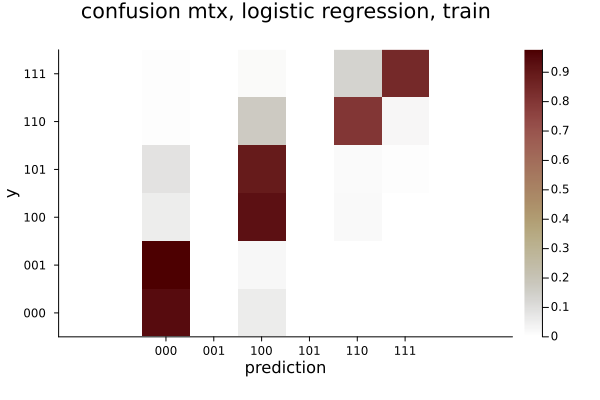

In [272]:
heatmap(mapslices(s->s./vec(sum(cm, dims=2)), cm, dims=1),
    title="confusion mtx, logistic regression, train",
    ylabel="y", xlabel="prediction",
    rightmargin = 5Plots.Measures.mm,
    tick_dir=:out,
    ratio=1, grid=false,
    xticks = (1:6, ["000", "001", "100", "101", "110", "111"]), 
    yticks = (1:6, ["000", "001", "100", "101", "110", "111"]),
    c=:bilbao)

In [275]:
savefig(joinpath(pdir, "TrainingData_out-of-fold-predictions_confusionplot.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB_predictivemodels/TrainingData_out-of-fold-predictions_confusionplot.pdf"

In [254]:
sum(.!inBB673)

59

In [255]:
cm |> typeof |> fieldnames

(:parent,)

In [256]:
testdf = DataFrame(
    :earlywindowdist => Dij_ew[.!inBB673, .!inBB673][test_uppertri],
    :middlewindowdist => Dij_mw[.!inBB673, .!inBB673][test_uppertri],
    :latewindowdist => Dij_lw[.!inBB673, .!inBB673][test_uppertri],
    :samephylum => (biobank.obs.phylum .== permutedims(biobank.obs.phylum))[.!inBB673, .!inBB673][test_uppertri],
    :samefamily => (biobank.obs.family .== permutedims(biobank.obs.family))[.!inBB673, .!inBB673][test_uppertri],
    :samespecies=> (biobank.obs.species .== permutedims(biobank.obs.species))[.!inBB673, .!inBB673][test_uppertri],
    :samedonor => (biobank.obs.donor .== permutedims(biobank.obs.donor))[.!inBB673, .!inBB673][test_uppertri],
);

In [257]:
testdf

Row,earlywindowdist,middlewindowdist,latewindowdist,samephylum,samefamily,samespecies,samedonor
,Float64,Float64,Float64,Bool,Bool,Bool,Bool
1,9.6151e-10,6.71868e-7,0.000471012,true,true,true,true
2,5.54707e-5,0.0107538,1.45193,true,false,false,false
3,5.53226e-5,0.010763,1.44785,true,false,false,false
4,5.44094e-8,6.97056e-6,0.000526892,true,true,true,true
5,5.67864e-8,6.43435e-6,5.87784e-5,true,true,true,true
6,5.5824e-5,0.0107665,1.44773,true,false,false,false
7,9.6151e-10,6.71868e-7,0.000471012,true,true,true,true
8,0.0,2.79967e-20,1.26572e-17,true,true,true,true
9,5.53226e-5,0.010763,1.44785,true,false,false,false


In [261]:
mach_small

trained Machine; caches model-specific representations of data
  model: MultinomialClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @783 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @652 ⏎ AbstractVector{OrderedFactor{6}}


In [262]:
ytest = hcat(testdf[:, :samephylum], testdf[:, :samespecies], testdf[:, :samedonor]) |>
    x->mapslices(x->join(Int.(x)), x, dims=2) |>
    vec;
ytest = coerce(ytest, Multiclass);

In [263]:
countmap(ytest)

Dict{CategoricalArrays.CategoricalValue{String, UInt32}, Int64} with 4 entries:
  "111" => 282
  "101" => 34
  "110" => 30
  "100" => 1365

In [264]:
Xtest = testdf[:, Xargs];

In [265]:
ŷ_test = MLJ.predict_mode(mach_small, Xtest);

In [266]:
cmt = confusion_matrix(ytest, ŷ_test)

6×6 Matrix{Int64}:
 668  0  635  0  61    1
   0  0   26  0   8    0
   2  0   11  0  16    1
   3  0   20  0   0  259
   0  0    0  0   0    0
   0  0    0  0   0    0

In [267]:
sum(cmt.mat[1:4, :], dims=2)

4×1 Matrix{Int64}:
 1365
   34
   30
  282

In [268]:
countmap(ytest)

Dict{CategoricalArrays.CategoricalValue{String, UInt32}, Int64} with 4 entries:
  "111" => 282
  "101" => 34
  "110" => 30
  "100" => 1365

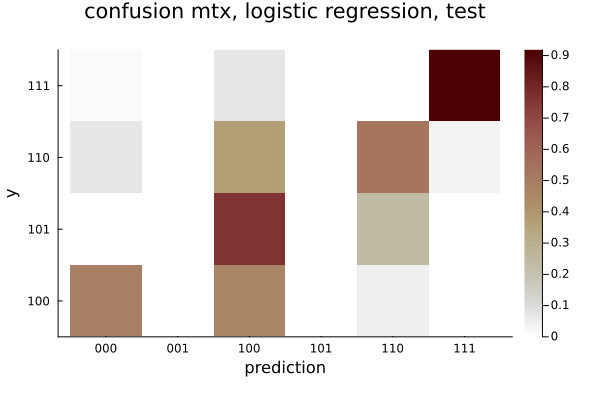

In [276]:
heatmap(mapslices(s->s./vec(sum(cmt.mat[1:4, :], dims=2)), cmt.mat[1:4, :], dims=1),
    title="confusion mtx, logistic regression, test",
    ylabel="y", xlabel="prediction",
    rightmargin = 5Plots.Measures.mm,
    ratio=1, grid=false,
    xticks = (1:6, ["000", "001", "100", "101", "110", "111"]), 
    yticks = (1:4, ["100", "101", "110", "111"]),
    c=:bilbao)

In [277]:
savefig(joinpath(pdir, "TestData_outofdataset_confusionplot.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB_predictivemodels/TestData_outofdataset_confusionplot.pdf"

In [270]:
fitted_params(mach_small)

(classes = CategoricalArrays.CategoricalValue{String, UInt32}["000", "001", "100", "101", "110", "111"],
 coefs = Pair{Symbol, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}[:earlywindowdist => [1158.9046172888704, 1230.5900471735608, -1906.3636597900568, -466.3310855487404, -22.236344353698975, 5.436425230026023], :middlewindowdist => [54.033495527485265, 58.15559055744397, 9.36477516740336, -27.00124975086874, -80.212283339427, -14.340328162025243], :latewindowdist => [0.3023541571375626, -0.03546833950402006, 3.372847843016915, 3.2978389402741066, -1.3171230293428757, -5.620449571716647]],
 intercept = [0.30952017267008797, -1.9503583259406483, -3.1508799514243364, -5.562637023523347, 4.393098218333962, 5.961256910188246],)

In [271]:
mach_small

trained Machine; caches model-specific representations of data
  model: MultinomialClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @783 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @652 ⏎ AbstractVector{OrderedFactor{6}}
